# Bayesian Multiple Regression Example

In [1]:
import arviz as az
import bambi as bmb
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
az.style.use('arviz-darkgrid')
np.random.seed(1234)

## Load and examine Eugene-Springfield community sample data

In [3]:
data = pd.read_csv('data/ESCS.csv')
np.round(data.describe(), 2)

,drugs,n,e,o,a,c,hones,emoti,extra,agree,consc,openn
count,604.00,604.00,604.00,604.00,604.00,604.00,604.00,604.00,604.00,604.00,604.00,604.00
mean,2.21,80.04,106.52,113.87,124.63,124.23,3.89,3.18,3.21,3.13,3.57,3.41
std,0.65,23.21,19.88,21.12,16.67,18.69,0.45,0.46,0.53,0.47,0.44,0.52
min,1.00,23.00,42.00,51.00,63.00,44.00,2.56,1.47,1.62,1.59,2.00,1.28
25%,1.71,65.75,93.00,101.00,115.00,113.00,3.59,2.88,2.84,2.84,3.31,3.06
50%,2.14,76.00,107.00,112.00,126.00,125.00,3.88,3.19,3.22,3.16,3.56,3.44
75%,2.64,93.00,120.00,129.00,136.00,136.00,4.20,3.47,3.56,3.44,3.84,3.75
max,4.29,163.00,158.00,174.00,171.00,180.00,4.94,4.62,4.75,4.44,4.75,4.72


It's always a good idea to start off with some basic plotting. Here's what our outcome variable 'drugs' (some index of self-reported illegal drug use) looks like:

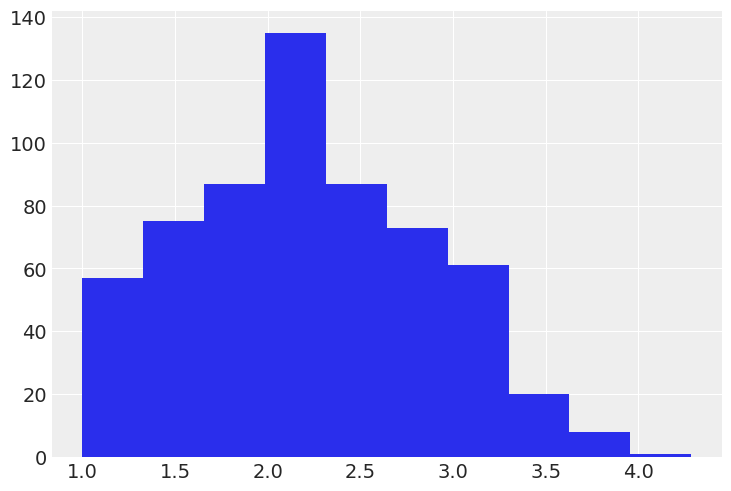

In [4]:
data['drugs'].hist();

The five numerical predictors that we'll use are sum-scores measuring participants' standings on the Big Five personality dimensions. The dimensions are:

- O = Openness to experience
- C = Conscientiousness
- E = Extraversion
- A = Agreeableness
- N = Neuroticism

Here's what our predictors look like:

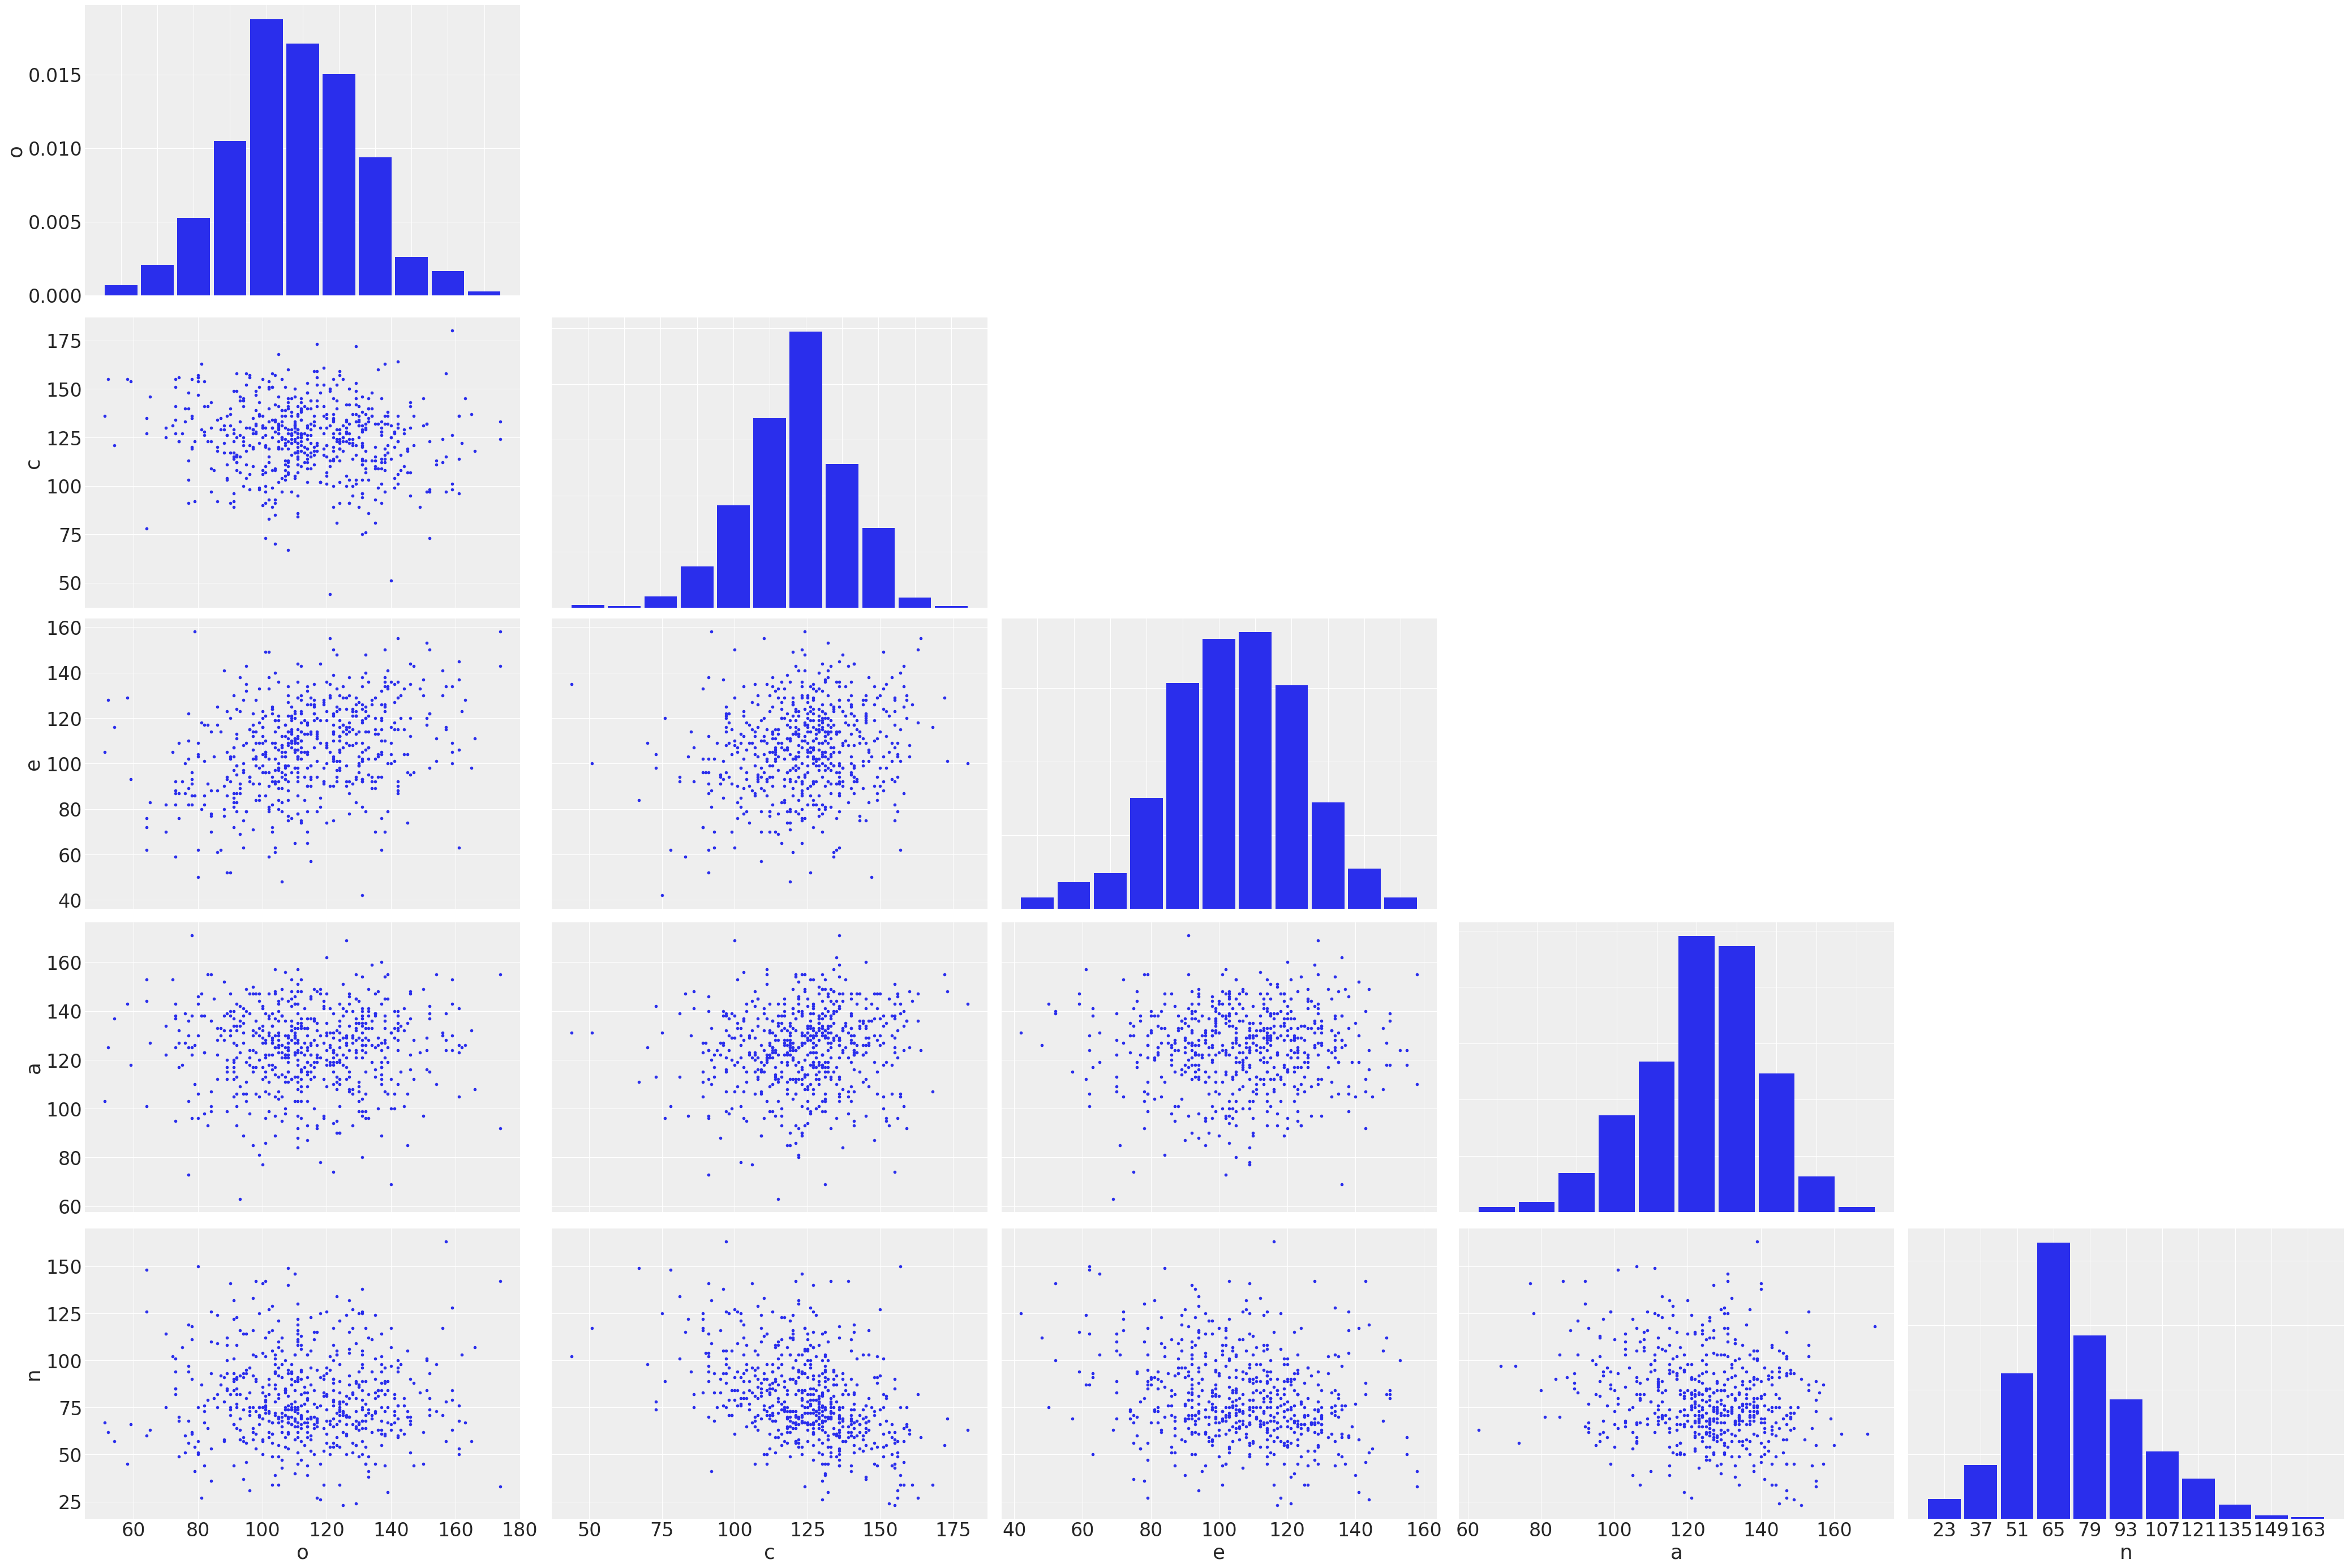

In [5]:
az.plot_pair(data[['o','c','e','a','n']].to_dict("list"), marginals=True, textsize=24);

We can easily see all the predictors are more or less symmetrically distributed without outliers and the pairwise correlations between them are not strong.

## Specify model and examine priors

We're going to fit a pretty straightforward additive multiple regression model predicting drug index from all 5 personality dimension scores. It's simple to specify the model using a familiar formula interface. Here we also tell Bambi to run two parallel Markov Chain Monte Carlo (MCMC) chains, each one with 2000 draws. The first 1000 draws are tuning steps that we discard and the last 1000 draws are considered to be taken from the joint posterior distribution of all the parameters (to be confirmed when we analyze the convergence of the chains).

In [6]:
model = bmb.Model(data)
fitted = model.fit('drugs ~ o + c + e + a + n', draws=1000, tune=1000, init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [drugs_sigma, n, a, e, c, o, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 18 seconds.


Great! But this is a Bayesian model, right? What about the priors?
If no priors are given explicitly by the user, then Bambi chooses smart default priors for all parameters of the model based on the implied partial correlations between the outcome and the predictors. Here's what the default priors look like in this case -- the plots below show 1000 draws from each prior distribution:

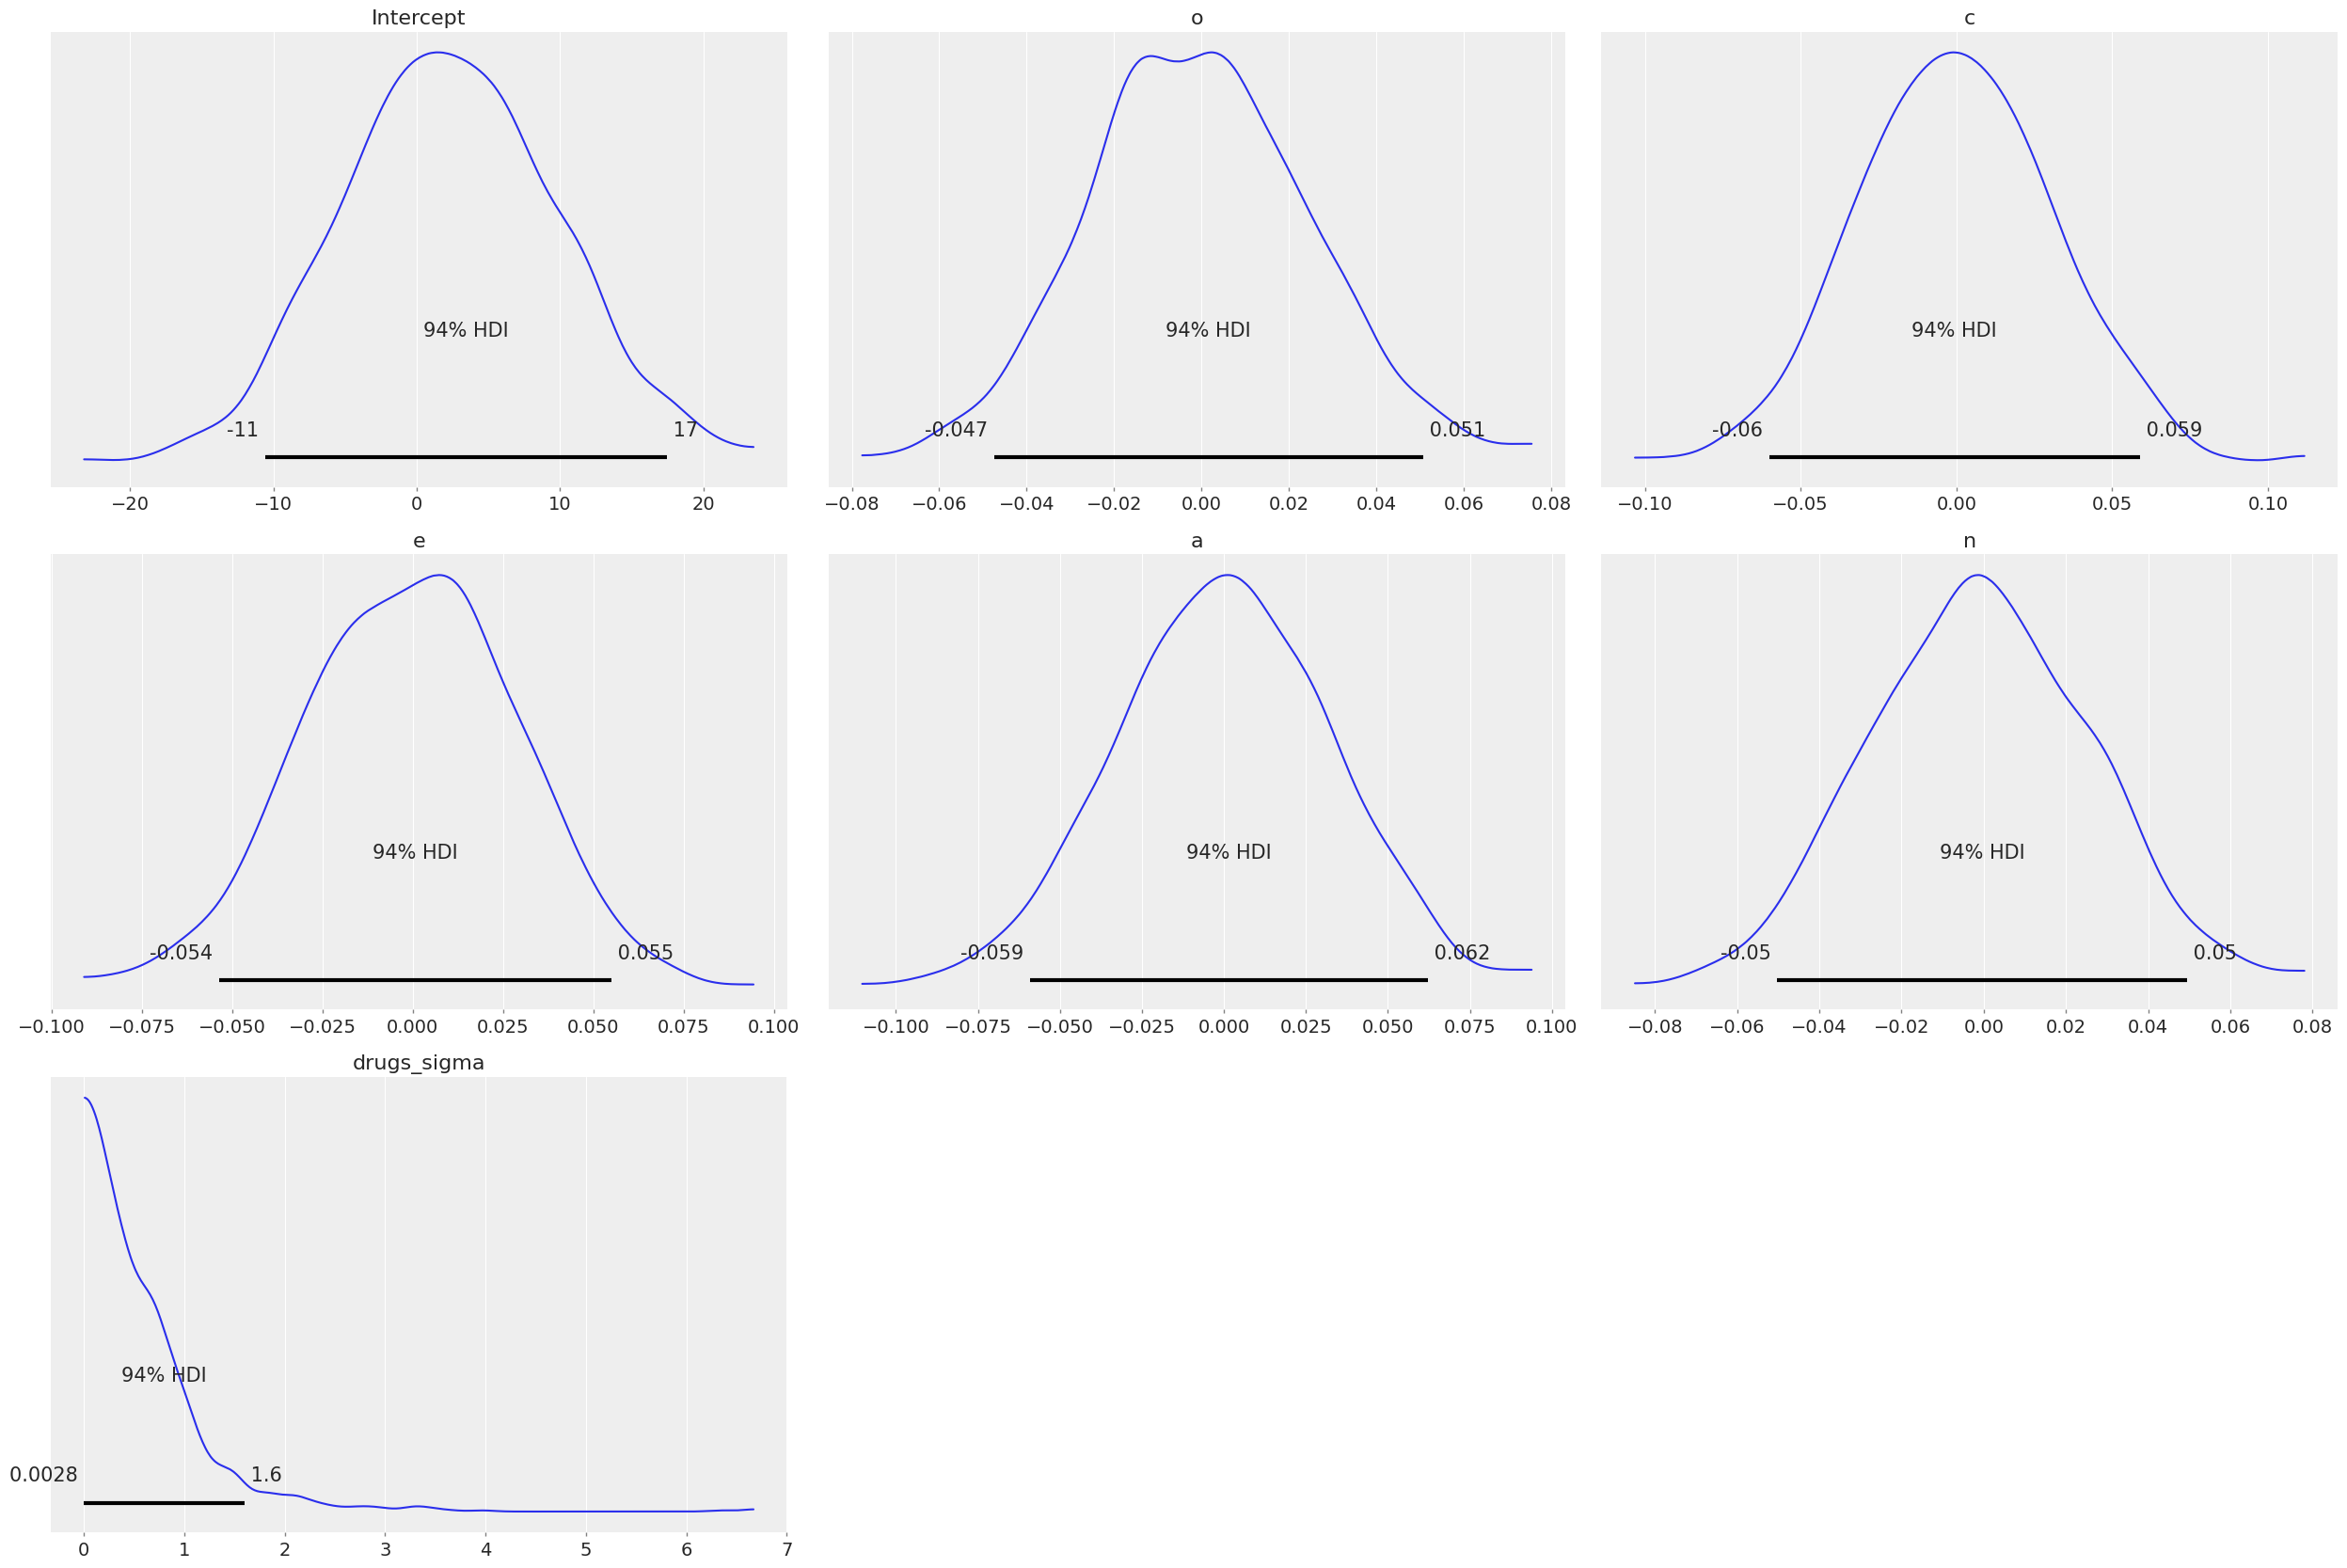

In [7]:
model.plot();

In [8]:
# Normal priors on the coefficients
{x.name:x.prior.args for x in model.terms.values()}

{'Intercept': {'mu': array([2.21014664]), 'sigma': array([7.49872452])},
 'o': {'mu': array([0]), 'sigma': array([0.02706881])},
 'c': {'mu': array([0]), 'sigma': array([0.03237049])},
 'e': {'mu': array([0]), 'sigma': array([0.02957414])},
 'a': {'mu': array([0]), 'sigma': array([0.03183623])},
 'n': {'mu': array([0]), 'sigma': array([0.02641989])}}

In [9]:
# HalfStudentT prior on the residual standard deviation
model.y.prior.args['sigma'].args

{'nu': array(4), 'sigma': array(0.64877877)}

Some more info about the default prior distributions can be found in [this technical paper](https://arxiv.org/abs/1702.01201).

Notice the small SDs of the slope priors. This is due to the relative scales of the outcome and the predictors: remember from the plots above that the outcome, `drugs`, ranges from 1 to about 4, while the predictors all range from about 20 to 180 or so. So a one-unit change in any of the predictors -- which is a trivial increase on the scale of the predictors -- is likely to lead to a very small absolute change in the outcome. Believe it or not, these priors are actually quite wide on the partial correlation scale!

## Examine the model results

Let's start with a pretty picture of the parameter estimates!

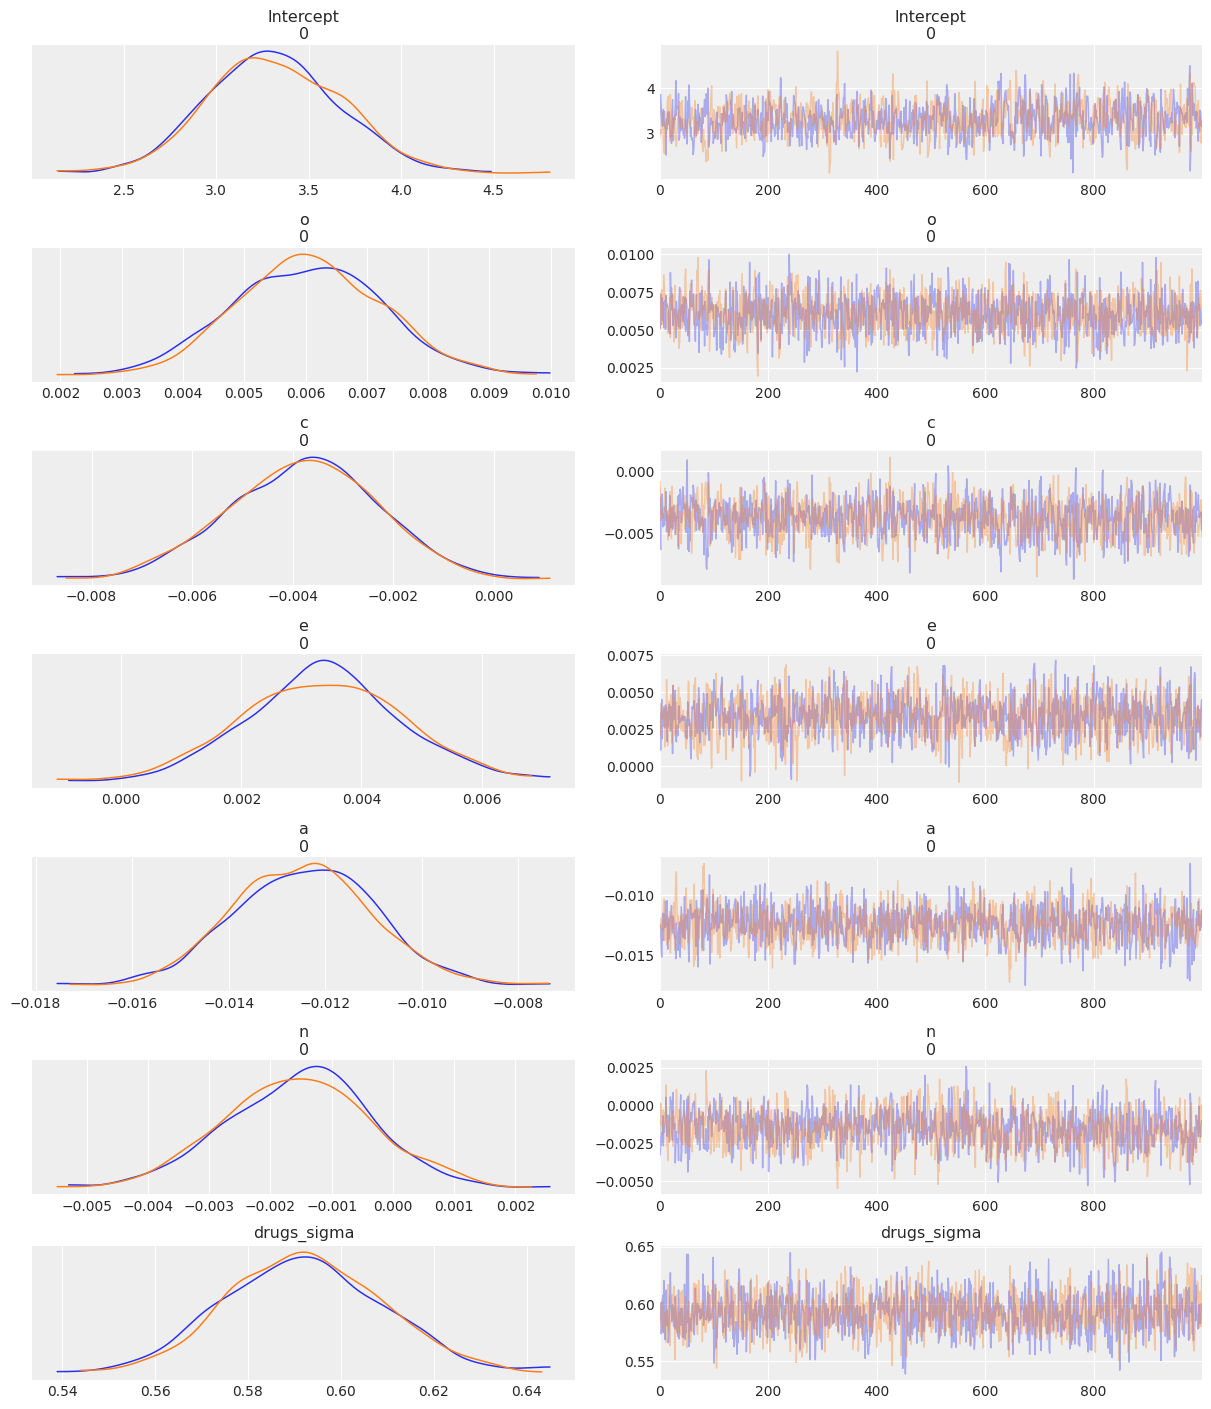

In [10]:
az.plot_trace(fitted);

The left panels show the marginal posterior distributions for all of the model’s parameters, which summarize the most plausible values of the regression coefficients, given the data we have now observed. These posterior density plots show two overlaid distributions because we ran two MCMC chains. The panels on the right are "trace plots" showing the sampling paths of the two MCMC chains as they wander through the parameter space. If any of these paths exhibited a pattern other than white noise we would be concerned about the convergence of the chains.

A much more succinct (non-graphical) summary of the parameter estimates can be found like so:

In [11]:
az.summary(fitted)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept[0],3.311,0.356,2.687,3.984,0.012,0.009,866.0,866.0,868.0,999.0,1.01
o[0],0.006,0.001,0.004,0.008,0.000,0.000,1553.0,1553.0,1551.0,1531.0,1.00
c[0],-0.004,0.001,-0.007,-0.001,0.000,0.000,1257.0,1205.0,1263.0,1376.0,1.00
e[0],0.003,0.001,0.001,0.006,0.000,0.000,1412.0,1381.0,1404.0,1256.0,1.00
a[0],-0.012,0.001,-0.015,-0.010,0.000,0.000,1221.0,1221.0,1232.0,1510.0,1.00
n[0],-0.002,0.001,-0.004,0.001,0.000,0.000,1120.0,1075.0,1129.0,1194.0,1.01
drugs_sigma,0.592,0.017,0.560,0.624,0.000,0.000,1688.0,1688.0,1682.0,1303.0,1.00


When there are multiple MCMC chains, the default summary output includes some basic convergence diagnostic info (the effective MCMC sample sizes and the Gelman-Rubin "R-hat" statistics), although in this case it's pretty clear from the trace plots above that the chains have converged just fine.

## Summarize effects on partial correlation scale

In [12]:
samples = fitted.posterior

It turns out that we can convert each regression coefficient into a partial correlation by multiplying it by a constant that depends on (1) the SD of the predictor, (2) the SD of the outcome, and (3) the degree of multicollinearity with the set of other predictors. Two of these statistics are actually already computed and stored in the fitted model object, in a dictionary called `dm_statistics` (for design matrix statistics), because they are used internally. We will compute the others manually.

Some more information about the relationship between linear regression parameters and partial correlation can be found
[here](https://stats.stackexchange.com/questions/76815/multiple-regression-or-partial-correlation-coefficient-and-relations-between-th).

In [13]:
# the names of the predictors
varnames = ['o', 'c', 'e', 'a', 'n']

# compute the needed statistics
r2_x = model.dm_statistics['r2_x']
sd_x = model.dm_statistics['sigma_x']
r2_y = pd.Series([sm.OLS(endog=data['drugs'],
                         exog=sm.add_constant(data[[p for p in varnames if p != x]])).fit().rsquared
                  for x in varnames], index=varnames)
sd_y = data['drugs'].std()

# compute the products to multiply each slope with to produce the partial correlations
slope_constant = (sd_x[varnames] / sd_y) * ((1 - r2_x[varnames]) / (1 - r2_y)) ** 0.5
slope_constant

o    32.392557
c    27.674284
e    30.305117
a    26.113299
n    34.130431
dtype: float64

Now we just multiply each sampled regression coefficient by its corresponding `slope_constant` to transform it into a sample partial correlation coefficient.

In [14]:
pcorr_samples = samples[varnames] * slope_constant

And voilà! We now have a joint posterior distribution for the partial correlation coefficients. Let's plot the marginal posterior distributions:

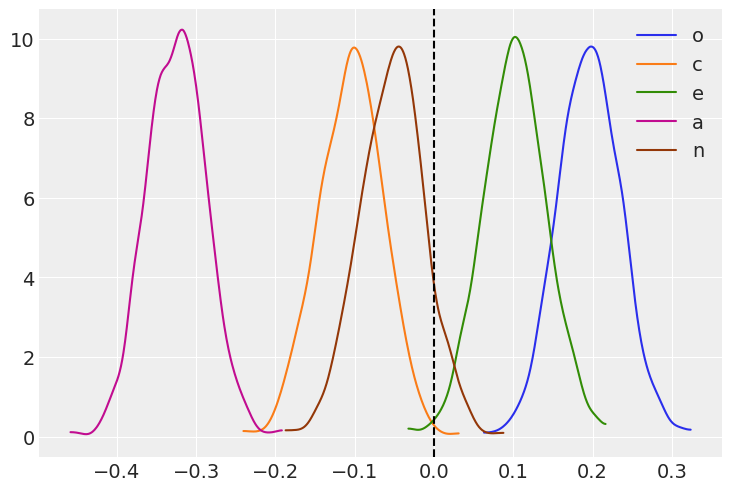

In [15]:
# Pass the same axes to az.plot_kde to have all the densities in the same plot
_, ax = plt.subplots()
for idx, (k, v) in enumerate(pcorr_samples.items()):
    az.plot_kde(v, label=k, plot_kwargs={'color':f'C{idx}'}, ax=ax)
ax.axvline(x=0, color='k', linestyle='--');

The means of these distributions serve as good point estimates of the partial correlations:

In [16]:
pcorr_samples.mean(dim=['chain', 'draw']).squeeze(drop=True)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    o        float64 0.1958
    c        float64 -0.1049
    e        float64 0.1015
    a        float64 -0.325
    n        float64 -0.05269

## Relative importance: Which predictors have the strongest effects (defined in terms of partial $\eta^2$)?

The partial $\eta^2$ statistics for each predictor are just the squares of the partial correlation coefficients, so it's easy to get posteriors on that scale too:

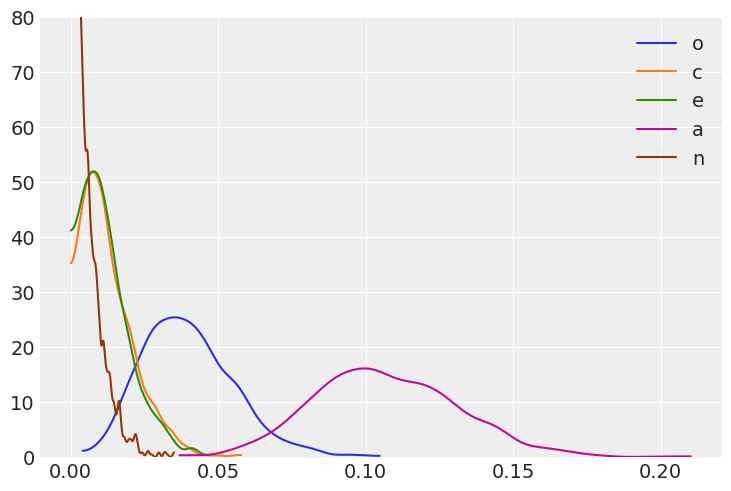

In [17]:
_, ax = plt.subplots()
for idx, (k, v) in enumerate(pcorr_samples.items()):
    az.plot_kde(v**2, label=k, plot_kwargs={'color':f'C{idx}'}, ax=ax)
ax.set_ylim(0, 80);

With these posteriors we can ask: What is the probability that the partial $\eta^2$ for Openness (blue) is greater than the partial $\eta^2$ for Conscientiousness (orange)?

For each predictor, what is the probability that it has the largest $\eta^2$?

In [18]:
pc_df = pcorr_samples.to_dataframe()
(pc_df**2).idxmax(axis=1).value_counts() / len(pc_df.index)

a    0.99
o    0.01
dtype: float64

Agreeableness is clearly the strongest predictor of drug use among the Big Five personality traits, but it's still not a particularly strong predictor in an absolute sense. Walter Mischel famously claimed that it is rare to see correlations between personality measurse and relevant behavioral outcomes exceed 0.3. In this case, the probability that the agreeableness partial correlation exceeds 0.3 is:

In [19]:
(np.abs(pcorr_samples['a']) > 0.3).mean()

<xarray.DataArray 'a' ()>
array(0.748)